## HW3 part A by Denis Osipychev
### Testing my DQN on CartPole
##### import gym and local environments

In [1]:
import gym, time
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
import tensorflow.contrib.slim as slim

In [2]:
# initialize the env and test it with a fixed action
env = gym.make("CartPole-v0")
env.reset()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


array([ 0.03568063,  0.04676258, -0.0463033 , -0.02170183])

In [3]:
# initialize hyperparameters
n_episodes = 5000
episode_lenght = 100
gamma = 0.99
alpha = 0.01
buffer_size = 1000
batch_size = 100
epsilon = 0.7 # it will vary during the training
n_neurons = 100

In [4]:
# nn structure for Q module
class Qnetwork():
    def __init__(self, input_size, layer_size, output_size):
        
        self.input = tf.placeholder(shape=[None,input_size],dtype=tf.float32)
        hidden = slim.fully_connected(self.input,layer_size,biases_initializer=None,activation_fn=tf.nn.relu)
        self.output = slim.fully_connected(hidden,output_size,biases_initializer=None)
        
        self.new_q = tf.placeholder(shape=[None,],dtype=tf.float32)
        self.action_holder = tf.placeholder(shape=[None,output_size],dtype=tf.float32)
        self.Q_action = tf.reduce_sum(tf.multiply(self.output,self.action_holder), reduction_indices=1)
        
        
        self.loss = tf.reduce_sum(tf.square(self.new_q - self.Q_action))
        optimizer = tf.train.AdamOptimizer(learning_rate=alpha)
        self.update_model = optimizer.minimize(self.loss)

In [5]:
# epsilon greedy policy
def greedy_policy(Q):
    if np.random.uniform() < epsilon:
        best_action = np.random.randint(env.action_space.n)
    else:
        best_action = np.argmax(Q)
    return best_action

In [6]:
class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, arg):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = arg
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        if len(self.memory) < batch_size:
            batch_size = len(self.memory)
        return random.sample(self.memory, batch_size)
    
    def size(self):
        return len(self.memory)

In [7]:
# initialize the weights and network
tf.reset_default_graph() # Clear the Tensorflow graph.
myAgent = Qnetwork(env.observation_space.shape[0], n_neurons, env.action_space.n)
merged = tf.summary.merge_all()
buffer = ReplayMemory(buffer_size)
epsilon_reduction = epsilon / n_episodes

In [8]:
# launch the session
sess = tf.Session()
sess.run(tf.global_variables_initializer())
print("Initialized Variables")

Initialized Variables


In [9]:
history = []
i = 0

# run the training
while i < n_episodes:
    
    s = env.reset()
    total_reward = 0
    i += 1
    j = 0
    d = False
    
    #run the simulation
    while j < episode_lenght:
        
        j += 1
        
        q = sess.run(myAgent.output,feed_dict={myAgent.input:[s]})
        action = greedy_policy(q)
        
        # do the step
        s_new,r,d,_ = env.step(action)
        
        action_one_hot = np.zeros(env.action_space.n)
        action_one_hot[action] = 1
        
        buffer.push([s,action_one_hot,r,d,s_new])
        
        total_reward += r
        s = s_new
        
        if buffer.size() > batch_size:
            st, at, rt, dt, snewt = zip(*buffer.sample(batch_size))
            qt = sess.run(myAgent.output,feed_dict={myAgent.input:snewt})
            yt = []
            for k in range(batch_size):
                if dt[k] == True:
                    yt.append(rt[k])
                else:
                    yt.append(rt[k] + gamma*np.max(qt[k]))
                
            _ = sess.run(myAgent.update_model,feed_dict={myAgent.input:st,
                                                         myAgent.action_holder:at,
                                                         myAgent.new_q:yt})
            
        # update q
        if d == True:
            break
            
    # decay exploration
    epsilon -= epsilon_reduction
    epsilon = max(0.01, epsilon)
    history.append([i, total_reward, epsilon, alpha, j])
    
    if i % 100 == 0:
        print(' Epoch:',i,',Average R:',np.mean(np.asarray(history)[-100:,1]),',Epsilon:', epsilon)

 Epoch: 100 ,Average R: 17.55 ,Epsilon: 0.6859999999999971
 Epoch: 200 ,Average R: 17.1 ,Epsilon: 0.6719999999999942
 Epoch: 300 ,Average R: 20.12 ,Epsilon: 0.6579999999999913
 Epoch: 400 ,Average R: 19.33 ,Epsilon: 0.6439999999999884
 Epoch: 500 ,Average R: 19.45 ,Epsilon: 0.6299999999999855
 Epoch: 600 ,Average R: 20.8 ,Epsilon: 0.6159999999999826
 Epoch: 700 ,Average R: 21.28 ,Epsilon: 0.6019999999999797
 Epoch: 800 ,Average R: 18.02 ,Epsilon: 0.5879999999999768
 Epoch: 900 ,Average R: 19.79 ,Epsilon: 0.5739999999999739
 Epoch: 1000 ,Average R: 19.57 ,Epsilon: 0.559999999999971
 Epoch: 1100 ,Average R: 18.79 ,Epsilon: 0.5459999999999681
 Epoch: 1200 ,Average R: 18.59 ,Epsilon: 0.5319999999999652
 Epoch: 1300 ,Average R: 17.37 ,Epsilon: 0.5179999999999623
 Epoch: 1400 ,Average R: 18.17 ,Epsilon: 0.5039999999999594
 Epoch: 1500 ,Average R: 19.52 ,Epsilon: 0.48999999999996047
 Epoch: 1600 ,Average R: 15.19 ,Epsilon: 0.4759999999999631
 Epoch: 1700 ,Average R: 17.63 ,Epsilon: 0.46199999

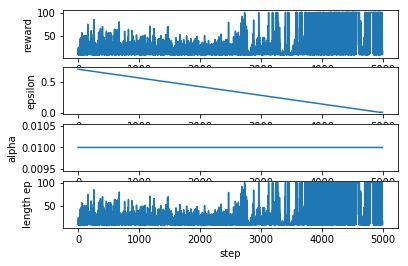

In [10]:
# plot the history
h = np.asarray(history)
plt.subplot(4, 1, 1)
plt.plot(h[:,0], h[:,1], '-')
plt.ylabel('reward')

plt.subplot(4, 1, 2)
plt.plot(h[:,0], h[:,2], '-')
plt.xlabel('step')
plt.ylabel('epsilon')

plt.subplot(4, 1, 3)
plt.plot(h[:,0], h[:,3], '-')
plt.xlabel('step')
plt.ylabel('alpha')

plt.subplot(4, 1, 4)
plt.plot(h[:,0], h[:,4], '-')
plt.xlabel('step')
plt.ylabel('length ep')

plt.show()

In [11]:
# ckpt = tf.train.get_checkpoint_state('./model')

# if ckpt and tf.train.checkpoint_exists(ckpt.model_checkpoint_path):
#     saver.restore(sess, ckpt.model_checkpoint_path)
#     print("Load Model : ", ckpt.model_checkpoint_path)
# else:
#     print("No policy for evaluation")

# evaluate the policy
s = env.reset()
total_reward = 0
j = 0

while j < episode_lenght:
    j += 1
    q = sess.run(myAgent.output,feed_dict={myAgent.input:[s]})
    action = np.argmax(q)
    s_new,r,d,_ = env.step(action)
    total_reward += r
    s = s_new
    env.render()
    #print("step:",j,",r:",r)
print("total reward:", total_reward)

total reward: 100.0


## HW3 part B by Denis Osipychev
### Training my DQN on Acrobot

In [36]:
import myenv
#dir(myenv)

# initialize the env
env = myenv.AcrobotEnv()
env.reset()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


array([ 2.28559075, -1.67222234,  0.83827331,  1.58108695])

In [41]:
# initialize hyperparameters
n_episodes = 10000
episode_lenght = 100
gamma = 0.99
alpha = 0.01
buffer_size = 1000
batch_size = 100
epsilon = 0.7 # it will vary during the training
n_neurons = 100

In [42]:
# initialize the weights and network
tf.reset_default_graph() # Clear the Tensorflow graph.
myAgent = Qnetwork(env.observation_space.shape[0], n_neurons, env.action_space.n)
merged = tf.summary.merge_all()
buffer = ReplayMemory(buffer_size)
epsilon_reduction = epsilon / n_episodes

In [43]:
# launch the session
sess = tf.Session()

# initialize, save or restore the network 
saver = tf.train.Saver(tf.global_variables())

writer = tf.summary.FileWriter('./logs', sess.graph)

ckpt = tf.train.get_checkpoint_state('./model')
if ckpt and tf.train.checkpoint_exists(ckpt.model_checkpoint_path):
    saver.restore(sess, ckpt.model_checkpoint_path)
    print("Load Model : ", ckpt.model_checkpoint_path)
else:
    sess.run(tf.global_variables_initializer())
    print("Initialized Variables")

Initialized Variables


In [44]:
history = []
i = 0

# run the training
while i < n_episodes:
    
    s = env.reset()
    total_reward = 0
    i += 1
    j = 0
    d = False
    
    #run the simulation
    while j < episode_lenght:
        
        j += 1
        
        q = sess.run(myAgent.output,feed_dict={myAgent.input:[s]})
        action = greedy_policy(q)
        
        # do the step
        s_new,r,d,_ = env.step(action)
        
        action_one_hot = np.zeros(env.action_space.n)
        action_one_hot[action] = 1
        
        buffer.push([s,action_one_hot,r,d,s_new])
        
#         q_next = sess.run(myAgent.output,feed_dict={myAgent.input:[s_new]})
#         targetq = q.flatten()
#         targetq[action] = r + gamma * np.max(q_next)
        
#         s_batch.append(s)
#         q_batch.append(q_next)
        
        total_reward += r
        s = s_new
        
        if buffer.size() > batch_size:
            st, at, rt, dt, snewt = zip(*buffer.sample(batch_size))
            qt = sess.run(myAgent.output,feed_dict={myAgent.input:snewt})
            yt = []
            for k in range(batch_size):
                if dt[k] == True:
                    yt.append(rt[k])
                else:
                    yt.append(rt[k] + gamma*np.max(qt[k]))
                
            _ = sess.run(myAgent.update_model,feed_dict={myAgent.input:st,
                                                         myAgent.action_holder:at,
                                                         myAgent.new_q:yt})
            
        # update q
    #if d == True:
            
            
    # decay exploration
    epsilon -= epsilon_reduction
    epsilon = max(0.01, epsilon)
    history.append([i, total_reward, epsilon, alpha, j])
    
    if i % 100 == 0:
        # save the model
        print(' Epoch:',i,',Average R:',np.mean(np.asarray(history)[-100:,1]),',Epsilon:', epsilon)
        saver.save(sess, './model/policy.ckpt')

 Epoch: 100 ,Average R: 0.31 ,Epsilon: 0.6929999999999985
 Epoch: 200 ,Average R: 0.51 ,Epsilon: 0.6859999999999971
 Epoch: 300 ,Average R: 0.19 ,Epsilon: 0.6789999999999956
 Epoch: 400 ,Average R: 0.25 ,Epsilon: 0.6719999999999942
 Epoch: 500 ,Average R: 0.15 ,Epsilon: 0.6649999999999927
 Epoch: 600 ,Average R: 0.39 ,Epsilon: 0.6579999999999913
 Epoch: 700 ,Average R: 0.35 ,Epsilon: 0.6509999999999898


KeyboardInterrupt: 

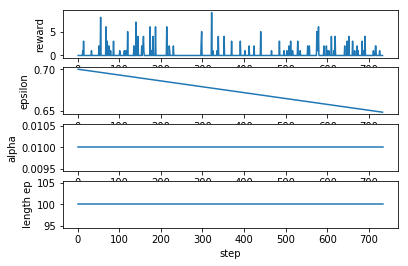

In [45]:
# plot the history
h = np.asarray(history)
plt.subplot(4, 1, 1)
plt.plot(h[:,0], h[:,1], '-')
plt.ylabel('reward')

plt.subplot(4, 1, 2)
plt.plot(h[:,0], h[:,2], '-')
plt.xlabel('step')
plt.ylabel('epsilon')

plt.subplot(4, 1, 3)
plt.plot(h[:,0], h[:,3], '-')
plt.xlabel('step')
plt.ylabel('alpha')

plt.subplot(4, 1, 4)
plt.plot(h[:,0], h[:,4], '-')
plt.xlabel('step')
plt.ylabel('length ep')

plt.show()

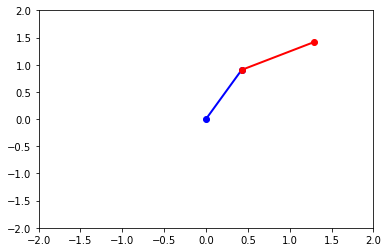

step: 1 ,r: 0


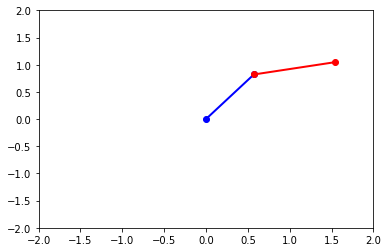

step: 2 ,r: 0


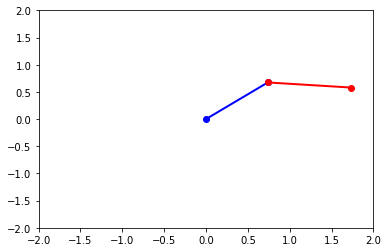

step: 3 ,r: 0


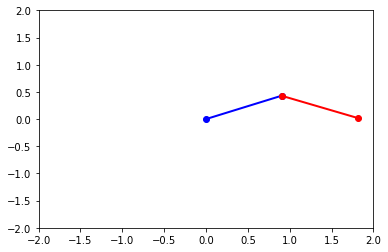

step: 4 ,r: 0


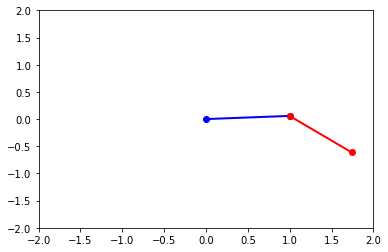

step: 5 ,r: 0


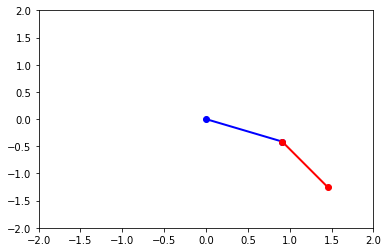

step: 6 ,r: 0


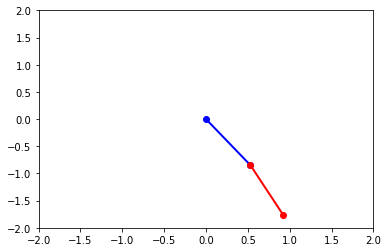

step: 7 ,r: 0


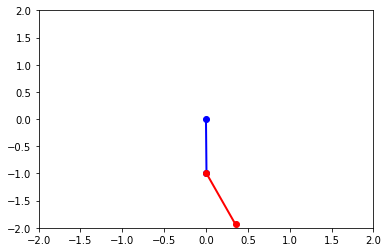

step: 8 ,r: 0


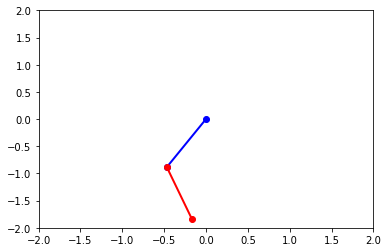

step: 9 ,r: 0


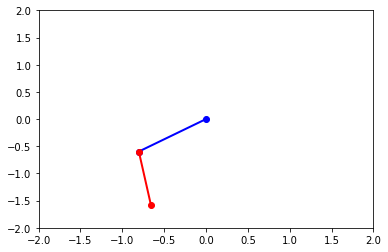

step: 10 ,r: 0


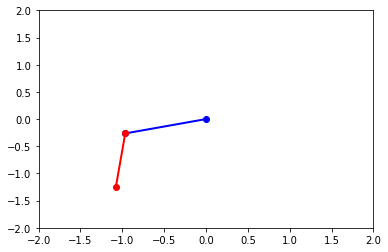

step: 11 ,r: 0


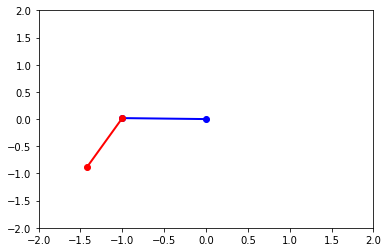

step: 12 ,r: 0


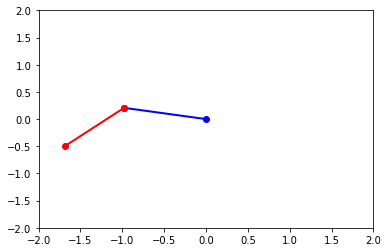

step: 13 ,r: 0


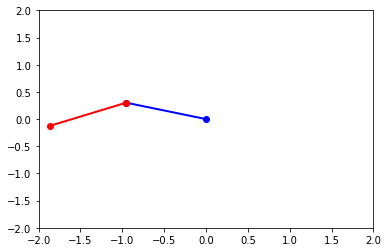

step: 14 ,r: 0


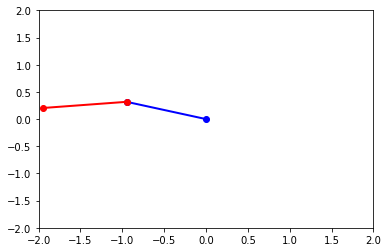

step: 15 ,r: 0


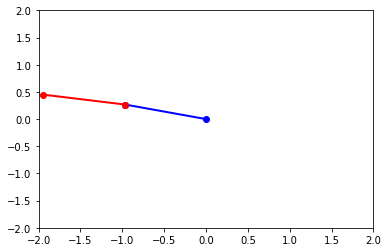

step: 16 ,r: 0


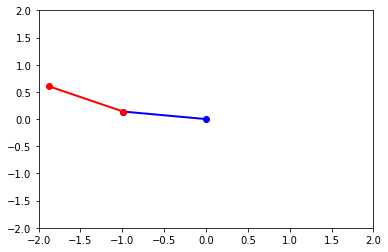

step: 17 ,r: 0


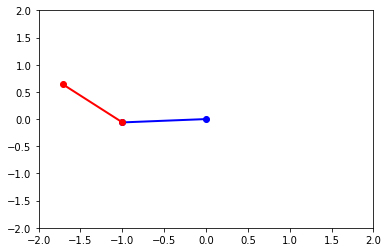

step: 18 ,r: 0


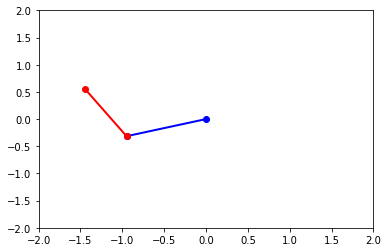

step: 19 ,r: 0


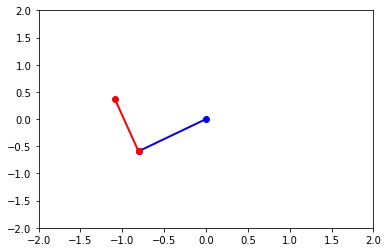

step: 20 ,r: 0


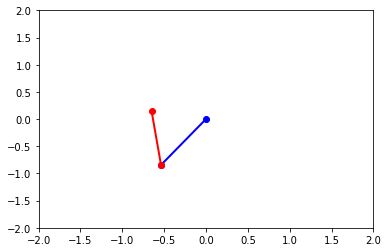

step: 21 ,r: 0


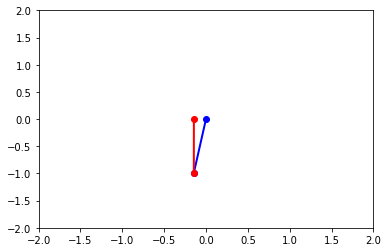

step: 22 ,r: 0


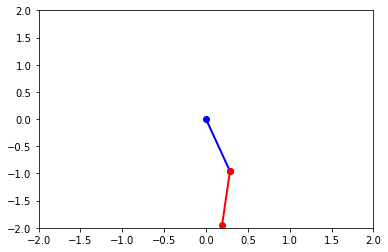

step: 23 ,r: 0


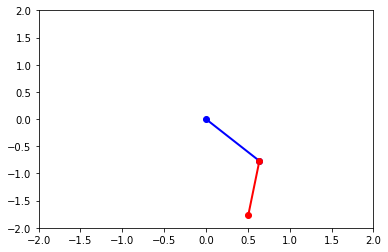

step: 24 ,r: 0


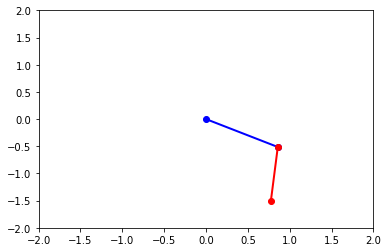

step: 25 ,r: 0


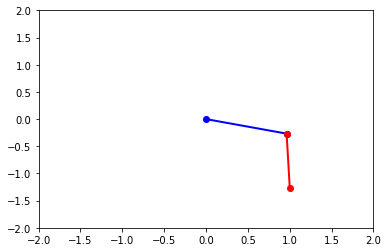

step: 26 ,r: 0


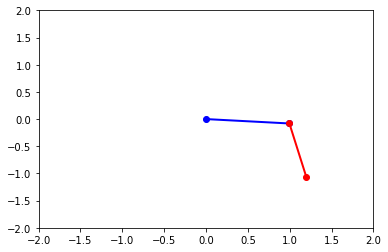

step: 27 ,r: 0


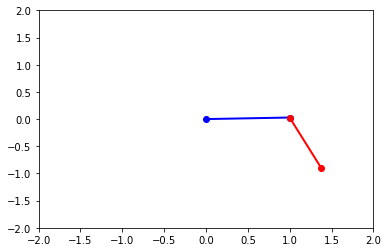

step: 28 ,r: 0


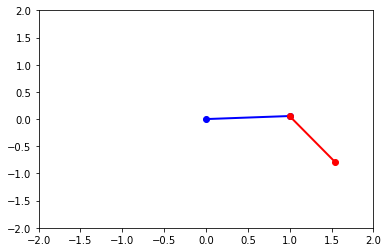

step: 29 ,r: 0


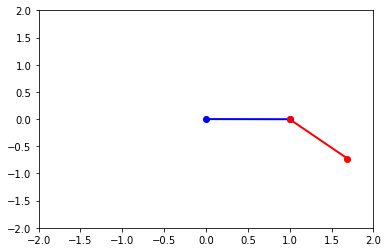

step: 30 ,r: 0


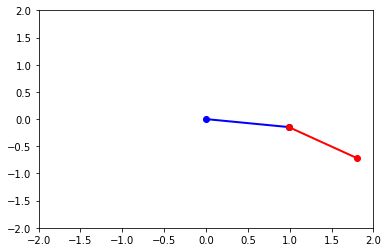

step: 31 ,r: 0


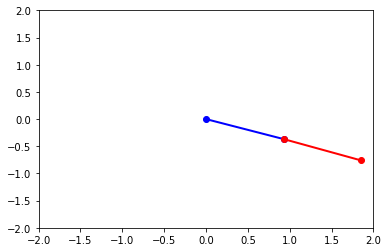

step: 32 ,r: 0


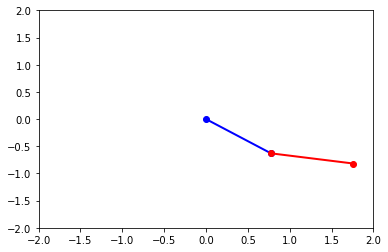

step: 33 ,r: 0


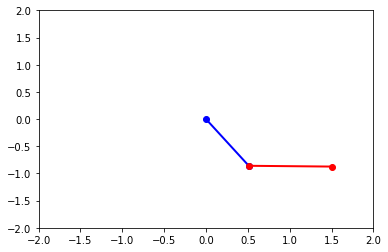

step: 34 ,r: 0


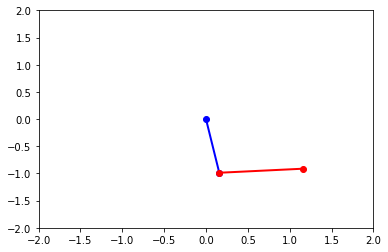

step: 35 ,r: 0


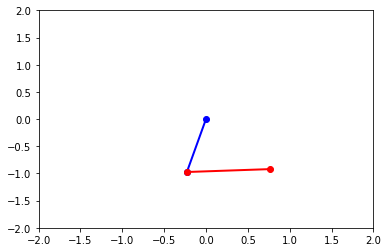

step: 36 ,r: 0


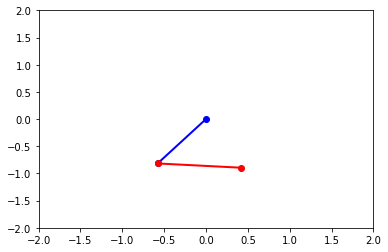

step: 37 ,r: 0


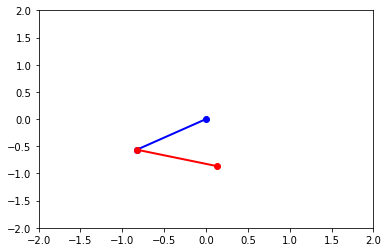

step: 38 ,r: 0


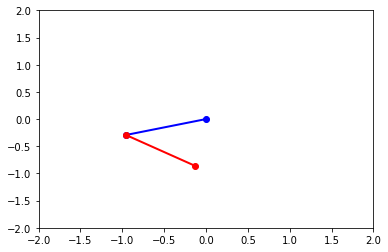

step: 39 ,r: 0


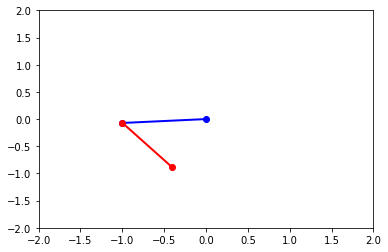

step: 40 ,r: 0


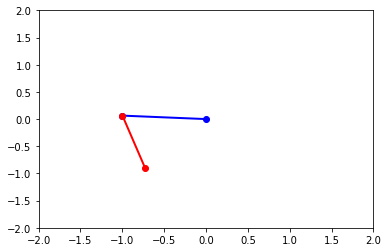

step: 41 ,r: 0


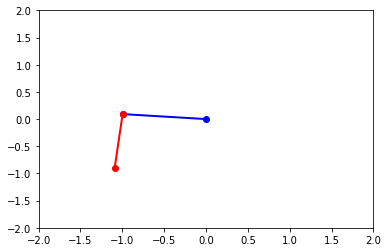

step: 42 ,r: 0


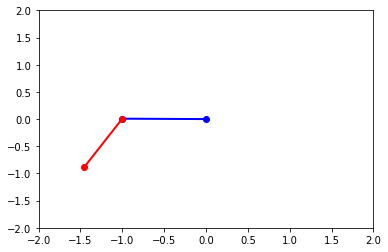

step: 43 ,r: 0


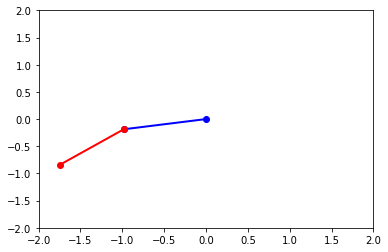

step: 44 ,r: 0


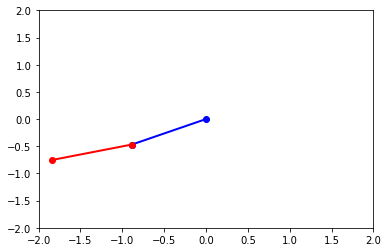

step: 45 ,r: 0


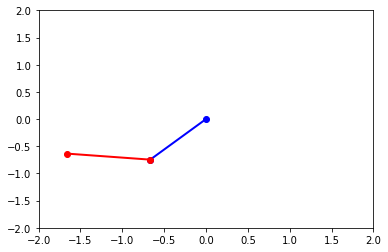

step: 46 ,r: 0


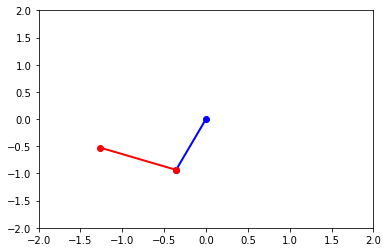

step: 47 ,r: 0


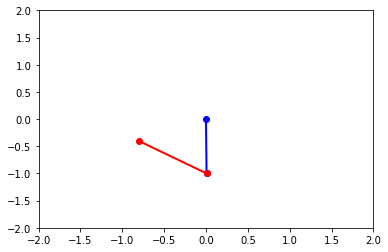

step: 48 ,r: 0


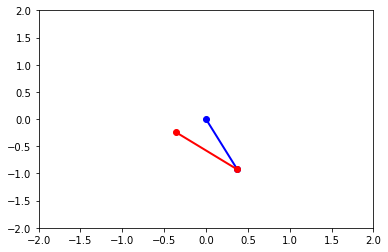

step: 49 ,r: 0


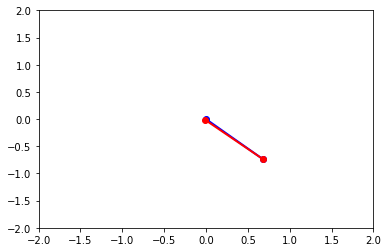

step: 50 ,r: 0


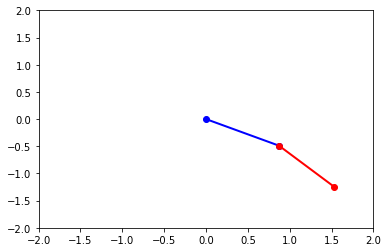

step: 51 ,r: 0


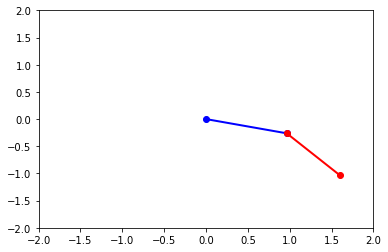

step: 52 ,r: 0


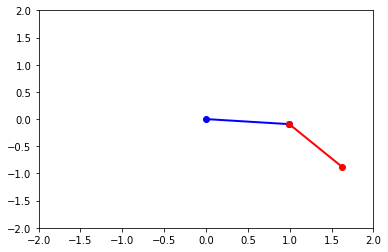

step: 53 ,r: 0


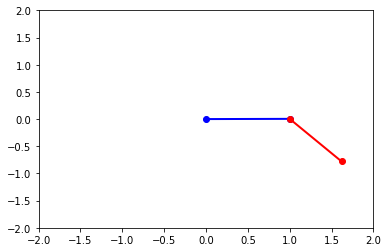

step: 54 ,r: 0


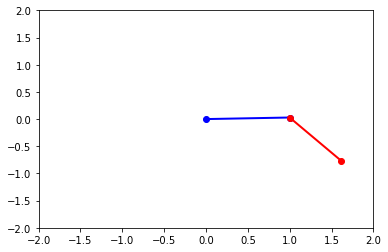

step: 55 ,r: 0


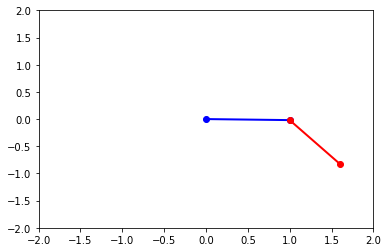

step: 56 ,r: 0


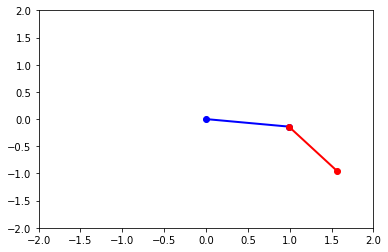

step: 57 ,r: 0


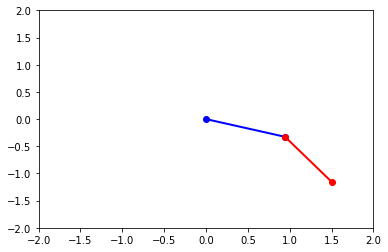

step: 58 ,r: 0


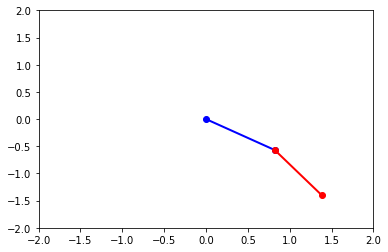

step: 59 ,r: 0


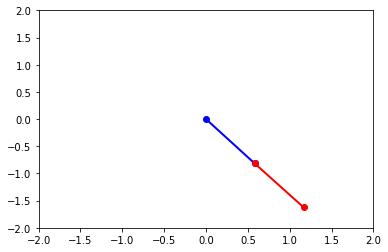

step: 60 ,r: 0


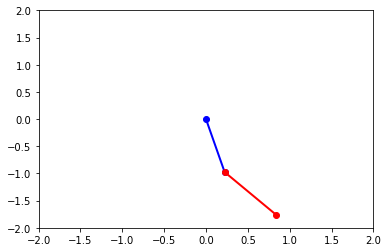

step: 61 ,r: 0


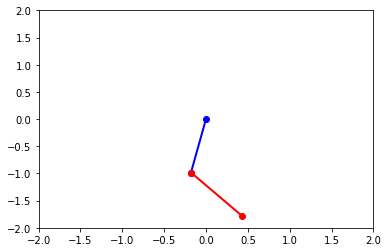

step: 62 ,r: 0


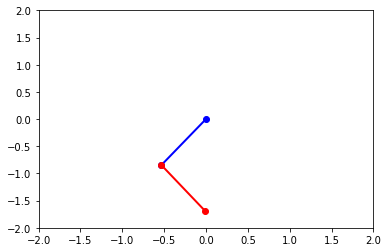

step: 63 ,r: 0


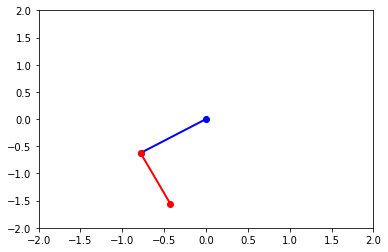

step: 64 ,r: 0


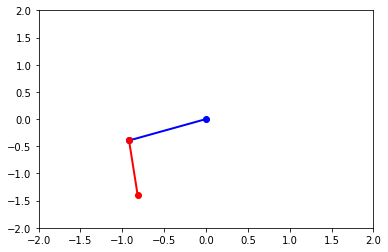

step: 65 ,r: 0


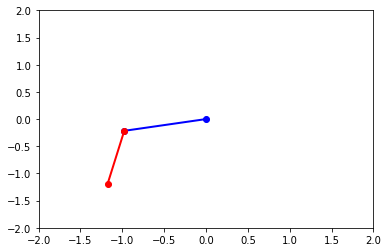

step: 66 ,r: 0


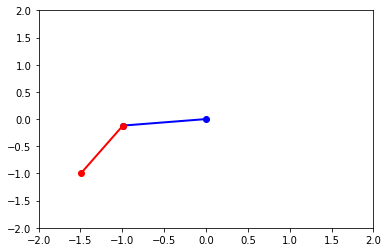

step: 67 ,r: 0


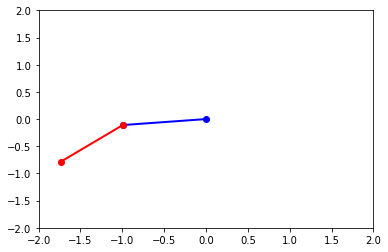

step: 68 ,r: 0


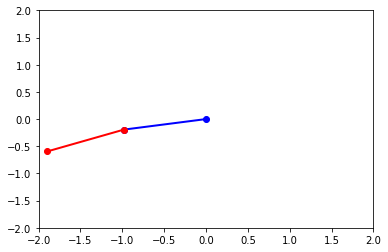

step: 69 ,r: 0


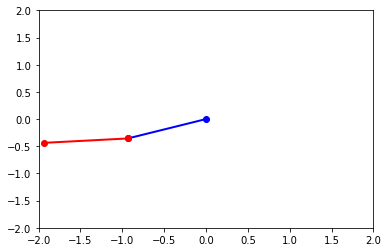

step: 70 ,r: 0


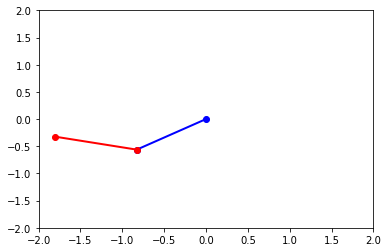

step: 71 ,r: 0


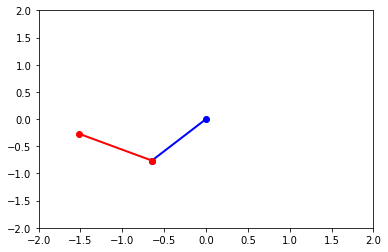

step: 72 ,r: 0


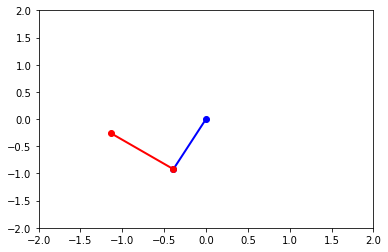

step: 73 ,r: 0


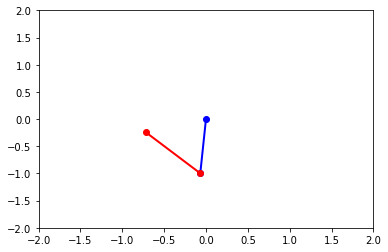

step: 74 ,r: 0


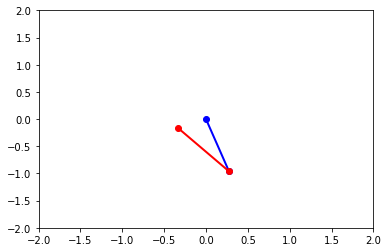

step: 75 ,r: 0


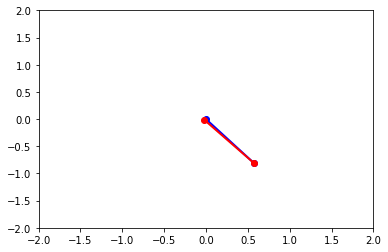

step: 76 ,r: 0


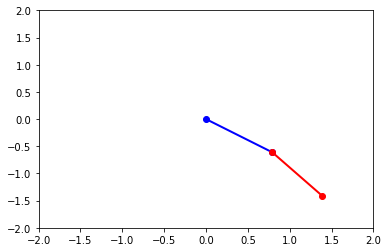

step: 77 ,r: 0


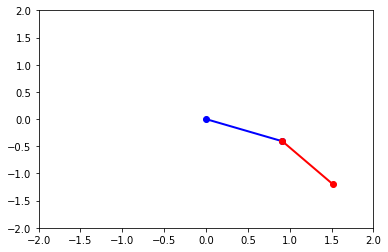

step: 78 ,r: 0


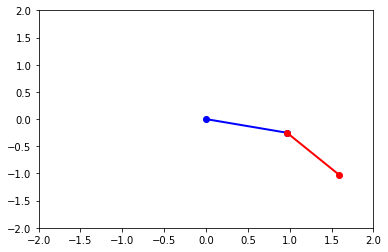

step: 79 ,r: 0


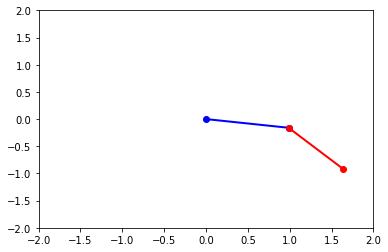

step: 80 ,r: 0


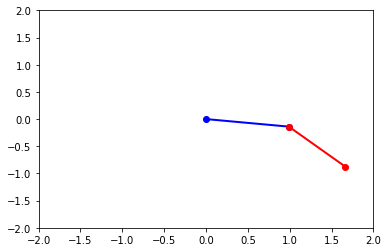

step: 81 ,r: 0


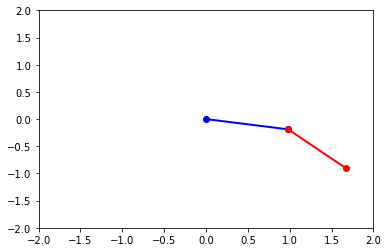

step: 82 ,r: 0


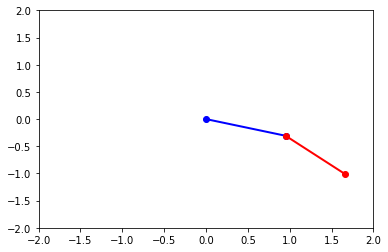

step: 83 ,r: 0


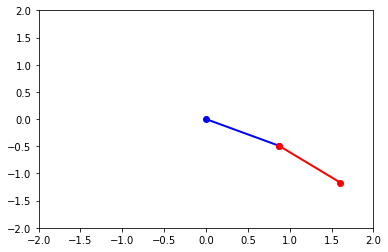

step: 84 ,r: 0


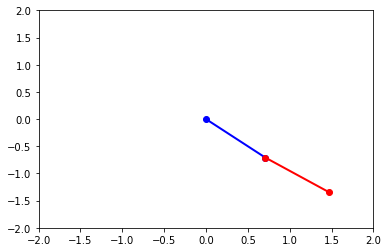

step: 85 ,r: 0


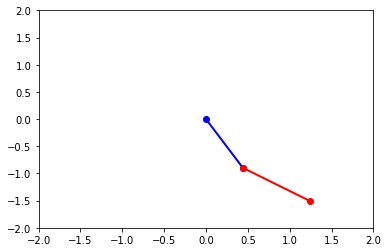

step: 86 ,r: 0


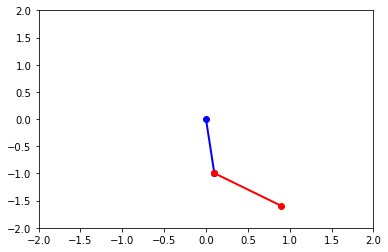

step: 87 ,r: 0


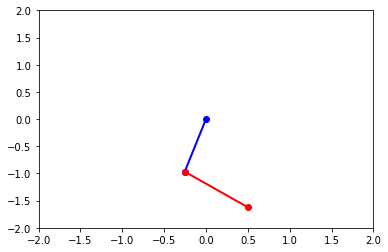

step: 88 ,r: 0


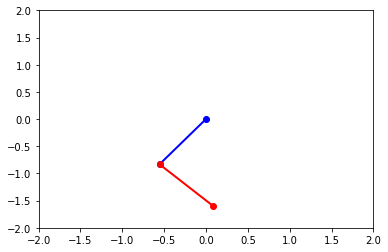

step: 89 ,r: 0


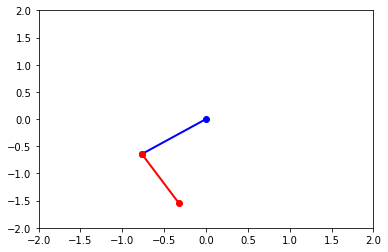

step: 90 ,r: 0


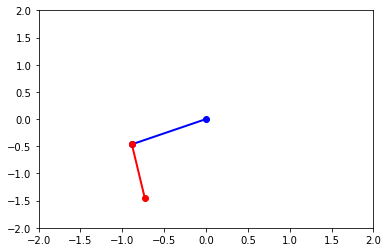

step: 91 ,r: 0


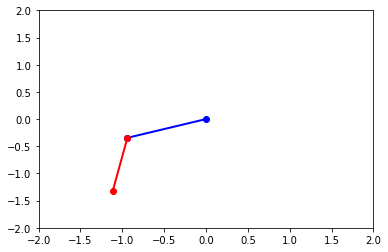

step: 92 ,r: 0


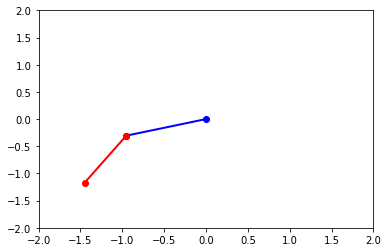

step: 93 ,r: 0


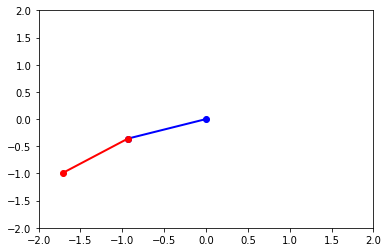

step: 94 ,r: 0


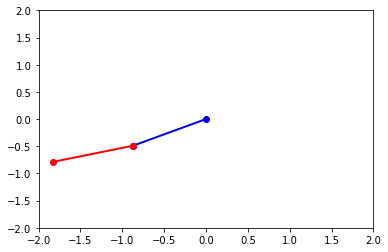

step: 95 ,r: 0


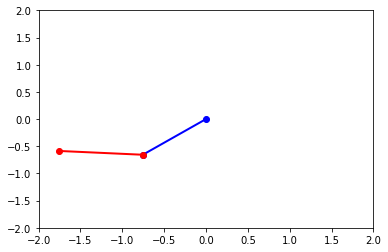

step: 96 ,r: 0


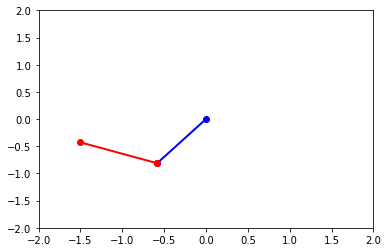

step: 97 ,r: 0


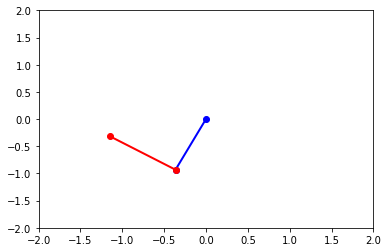

step: 98 ,r: 0


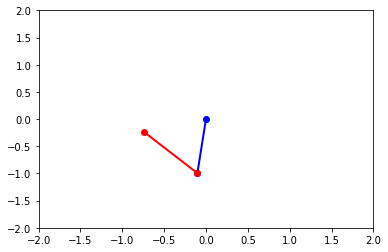

step: 99 ,r: 0


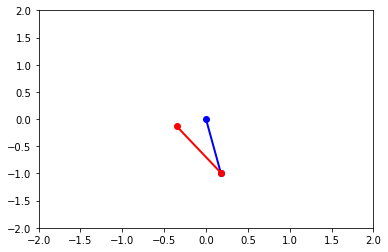

step: 100 ,r: 0
total reward: 0


In [46]:
# ckpt = tf.train.get_checkpoint_state('./model')

# if ckpt and tf.train.checkpoint_exists(ckpt.model_checkpoint_path):
#     saver.restore(sess, ckpt.model_checkpoint_path)
#     print("Load Model : ", ckpt.model_checkpoint_path)
# else:
#     print("No policy for evaluation")

# evaluate the policy
s = env.reset()
total_reward = 0
j = 0

while j < episode_lenght:
    j += 1
    q = sess.run(myAgent.output,feed_dict={myAgent.input:[s]})
    action = np.argmax(q)
    s_new,r,d,_ = env.step(action)
    total_reward += r
    s = s_new
    env.render()
    print("step:",j,",r:",r)
print("total reward:", total_reward)